# Intersection

In this notebook we demonstrate how to define a T-shape intersection with AutomotiveDrivingModels.  You will also learn how to define your own custom action type and driver model type.


In [1]:
using AutomotiveDrivingModels

# All the functions related to visualization
using AutoViz

## Generate a T-Shape intersection

In order to generate the road network, one first initializes a Roadway object.

In [2]:
roadway = Roadway();

In [3]:
# Define coordinates of the entry and exit points to the intersection
r = 5.0 # turn radius
A = VecSE2(0,DEFAULT_LANE_WIDTH,-π)
B = VecSE2(0,0,0)
C = VecSE2(r,-r,-π/2)
D = VecSE2(r+DEFAULT_LANE_WIDTH,-r,π/2)
E = VecSE2(2r+DEFAULT_LANE_WIDTH,0,0)
F = VecSE2(2r+DEFAULT_LANE_WIDTH,DEFAULT_LANE_WIDTH,-π)

3-element Vec.VecSE2{Float64}:
 13.0    
  3.0    
 -3.14159

The next step consists in appending all the lanes to the road network. We can define a helper function to add a new lane to the roadway.

In [4]:
function append_to_curve!(target::Curve, newstuff::Curve)
    s_end = target[end].s
    for c in newstuff
        push!(target, CurvePt(c.pos, c.s+s_end, c.k, c.kd))
    end
    return target
end

append_to_curve! (generic function with 1 method)

Example of a lane that consists in 3 road segments, a straight curve (from the left to the center), a turning part (right turn) and a final straight curve. You can visualize the lane that has been added to the roadway

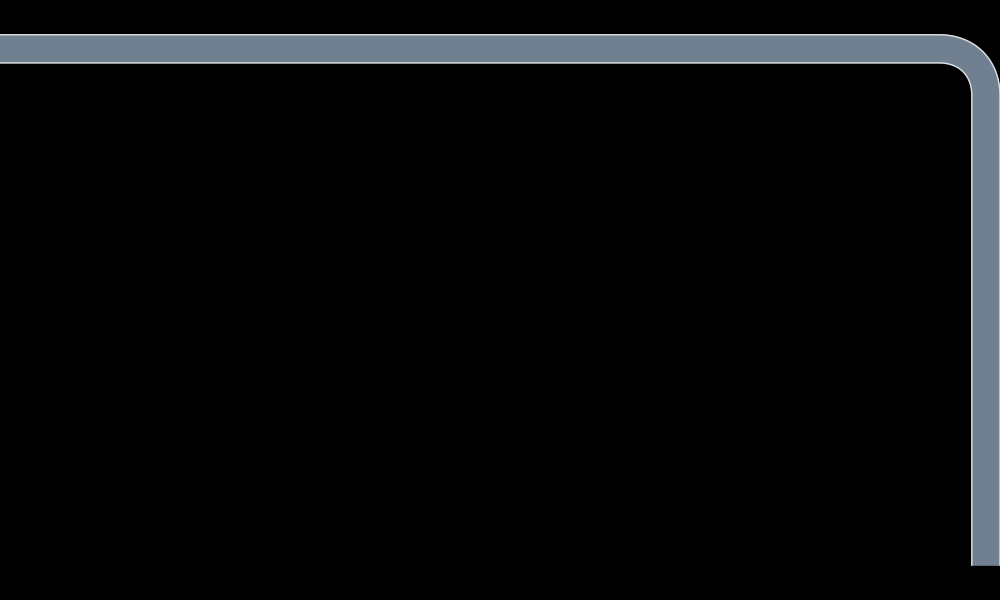

In [5]:
# Append right turn coming from the left
curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append_to_curve!(curve, gen_bezier_curve(B, C, 0.6r, 0.6r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50.0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

#visualize first lane
cam = FitToContentCamera(0.0)
render(roadway, cam=cam)

Let's repeat the process and complete the T-shape intersection

In [6]:
# Append straight left
curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append_to_curve!(curve, gen_straight_curve(convert(VecE2, B), convert(VecE2, E), 2)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

# Append straight right
curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append_to_curve!(curve, gen_straight_curve(convert(VecE2, F), convert(VecE2, A), 2)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

# Append left turn coming from the right
curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append_to_curve!(curve, gen_bezier_curve(F, C, 0.9r, 0.9r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

# Append right turn coming from below
curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append_to_curve!(curve, gen_bezier_curve(D, E, 0.6r, 0.6r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

# Append left turn coming from below
curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append_to_curve!(curve, gen_bezier_curve(D, A, 0.9r, 0.9r, 51)[2:end])
append_to_curve!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

cam = FitToContentCamera(0.0)
render(roadway, cam=cam)

We can identify each lane thanks to the following user-defined functions. We define a ```LaneOverlay``` object that indicate the lane to highlight. One could implement any custom type to display other information on the lane. We then add a new method to the  ```render!``` function that execute the specific action (coloring in blue). Look at Autoviz.jl for more detail on the ```render!``` function.

Use the slider to highlight each lane. The number corresponds to a road segment.

**Note :** In order to render the intersection, one must first initialize a ```Scene``` object.

In [7]:
using Interact

scene = Scene()

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

@manipulate for i in 1 : length(roadway.segments)
    render(scene, roadway, [LaneOverlay(roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=cam)
end

Interact.Options{:SelectionSlider,Int64}(1: "input" = 3 Int64 , "i", 3, "3", 3, Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6), Dict(4=>"4",2=>"2",3=>"3",5=>"5",6=>"6",1=>"1")), Any[], Any[], true, "horizontal", true)

## Navigate in the new road network

Let's populate the intersection

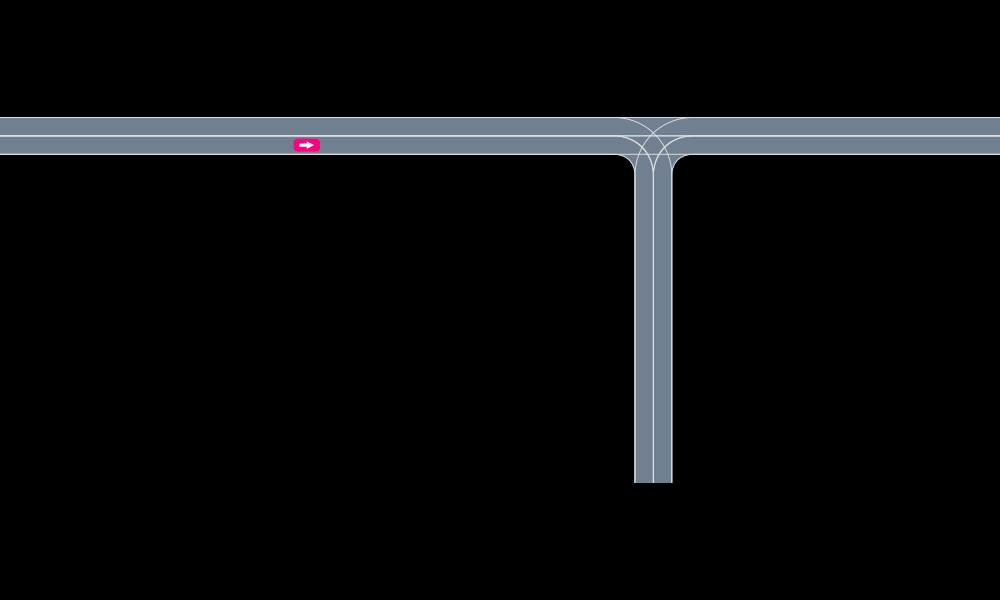

In [8]:
scene = Scene()
vs0 = VehicleState(B + polar(50.0,-π), roadway, 8.0) # initial state of the vehicle
push!(scene, Vehicle(vs0, VehicleDef(), 1)) # add vehicle with the default type

render(scene, roadway, cam=cam)

We will use lateral and longitudinal acceleration to control a car in the intersection. The first step is to define a corresponding action type that will contain the acceleration inputs.


In [9]:
immutable LaneSpecificAccelLatLon
    a_lat::Float64
    a_lon::Float64
end

Next, add a method to the propagate function to update the state using our new action type. 


**Note:** There is an existing propagate method to update the state using lateral and longitudinal acceleration. (it is used in line 3)

In [10]:
function AutomotiveDrivingModels.propagate(veh::Vehicle, action::LaneSpecificAccelLatLon, roadway::Roadway, Δt::Float64)
    lane_tag_orig = veh.state.posF.roadind.tag
    state = propagate(veh, LatLonAccel(action.a_lat, action.a_lon), roadway, Δt)
    roadproj = proj(state.posG, roadway[lane_tag_orig], roadway, move_along_curves=false)
    retval = VehicleState(Frenet(roadproj, roadway), roadway, state.v)
    return retval
end

**Driver Model:**

We define a driver model, which can be seen as a distribution over actions. Here we will define the simplest model, which is to repeat the same action.

In [11]:
type InterDriver <: DriverModel{LaneSpecificAccelLatLon}
    a::LaneSpecificAccelLatLon
end
AutomotiveDrivingModels.get_name(model::InterDriver) = "InterDriver"
Base.rand(model::InterDriver) = model.a

**Simulate: **

First associate a model to each driver in the scene using a dictionnary. Here we only have one driver identified by its ID: 1. Then everything is ready to run the ```simulate!``` function.

Interact.Options{:SelectionSlider,Int64}(5: "input-2" = 51 Int64 , "frame_index", 51, "51", 51, Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)), Any[], Any[], true, "horizontal", true)

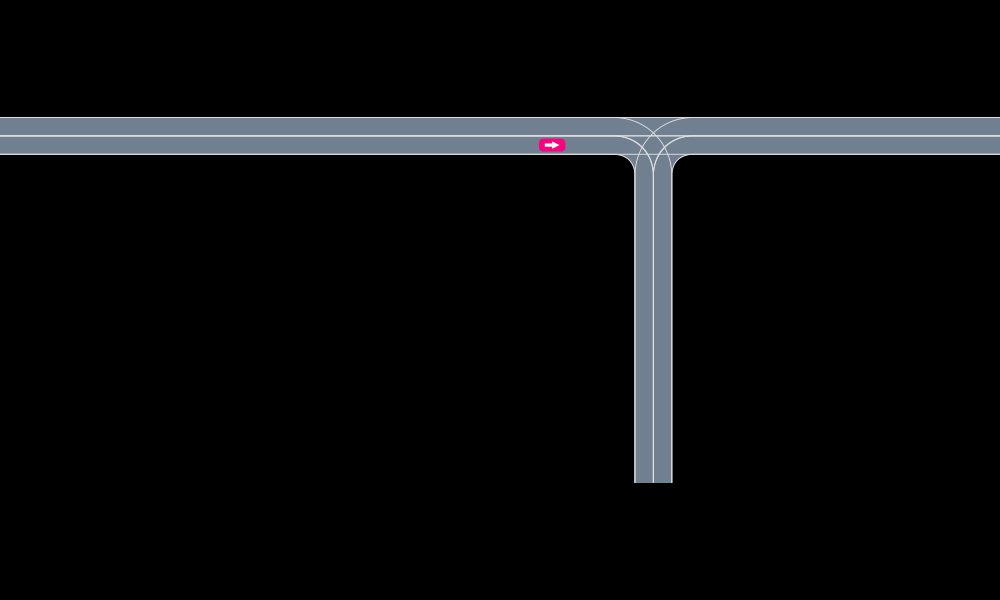

In [12]:
timestep = 0.1

models = Dict{Int, DriverModel}()
# constant speed model
models[1] = InterDriver(LaneSpecificAccelLatLon(0.0,0.0))

nticks = 100
rec = SceneRecord(nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)

# interactive visualization
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam)
end